# **Objective** -
To build a hybrid predictive maintenance model that first learns sensor-level degradation patterns using a 1D CNN and then performs long-range failure reasoning using a fine-tuned T5-small LLM on the extracted embeddings, in order to accurately classify early-warning engine failures.

# **References -**
https://drive.google.com/drive/folders/1AB45vN-2pSh6lZ1atUp2WsrRTpFOBgLc?usp=drive_link

# **Dataset** -
https://drive.google.com/drive/folders/1mmxgxl8Myc00fKl7i-f1vGUVHDZ5voup?usp=drive_link

#### 1D CNN for sensor patterns → Save embeddings



In [ ]:
# ============================================================
# 🔥 FINAL CNN + EMBEDDING EXTRACTION PIPELINE (FULL CODE)
# ============================================================

import warnings
warnings.filterwarnings('ignore')

# -------------------- 1. Upload TRAIN & TEST CSV --------------------
from google.colab import files
import pandas as pd
import numpy as np

print("📌 Upload TRAIN dataset CSV")
uploaded_train = files.upload()
train_path = list(uploaded_train.keys())[0]

print("\n📌 Upload TEST dataset CSV")
uploaded_test = files.upload()
test_path = list(uploaded_test.keys())[0]

# -------------------- 2. Column Rename + Structure ------------------
COLUMN_MAP = {f'OpSet{i}': f'op_setting_{i}' for i in range(1,4)}
COLUMN_MAP.update({f'Sensor{i}': f'sensor_measurement_{i}' for i in range(1,22)})
COLUMN_MAP['Label_RUL_30'] = 'RUL_binary'

def load_and_structure_data(file_path, fake_units):
    df = pd.read_csv(file_path)
    df.rename(columns=COLUMN_MAP, inplace=True)

    total_rows = len(df)
    cycles_per_unit = int(np.ceil(total_rows / fake_units))

    df['unit_number'] = np.repeat(range(1, fake_units+1), cycles_per_unit)[:total_rows]
    df['time_in_cycles'] = np.tile(range(1, cycles_per_unit+1), fake_units)[:total_rows]

    return df, cycles_per_unit

df_train, train_cycles = load_and_structure_data(train_path, fake_units=1000)
df_test, test_cycles   = load_and_structure_data(test_path,  fake_units=400)

# -------------------- 3. Scaling -------------------------------
from sklearn.preprocessing import MinMaxScaler

selected_sensors = [2,3,4,7,11,12,15,20,21]
feature_cols = [f'op_setting_{i}' for i in range(1,4)] + [
    f'sensor_measurement_{i}' for i in selected_sensors
]

scaler = MinMaxScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

# -------------------- 4. Class Weights -------------------------
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

labels = df_train['RUL_binary']
class_counts = labels.value_counts().sort_index()
weights = torch.tensor([len(labels)/(2*c) for c in class_counts]).float().to(DEVICE)

print("Class distribution:", class_counts.to_dict())

# -------------------- 5. Dataset with 15-cycle window --------------
from torch.utils.data import Dataset, DataLoader

CONTEXT_LENGTH = 15

class CNNDataset(Dataset):
    def __init__(self, df):
        self.samples = []
        for unit in df['unit_number'].unique():
            u = df[df['unit_number']==unit].sort_values('time_in_cycles')
            for i in range(CONTEXT_LENGTH-1, len(u)):
                ctx = u.iloc[i-CONTEXT_LENGTH+1:i+1]
                x = ctx[feature_cols].values.astype(np.float32)  # (15,12)
                y = int(ctx['RUL_binary'].iloc[-1])
                self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        x = torch.tensor(x).permute(1, 0)   # → [12, 15]
        return x, torch.tensor(y)

train_dataset = CNNDataset(df_train)
test_dataset  = CNNDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)

# -------------------- 6. CNN Model (Embedding Output) -----------------------------
import torch.nn as nn

class CNNBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        embed = self.pool(x).squeeze(-1)
        out = self.fc(embed)
        return out, embed

model = CNNBinaryClassifier().to(DEVICE)

# -------------------- 7. Training Loop -----------------------------
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 5
print("\n🚀 Training Started...\n")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {total_loss/len(train_loader):.4f}")

print("\n🎉 Training Complete!")

# -------------------- 8. Extract & Save Embeddings -----------------------------

def extract_embeddings(model, df):
    rows = []
    model.eval()

    for unit in df['unit_number'].unique():
        u = df[df['unit_number']==unit].sort_values('time_in_cycles')
        for i in range(CONTEXT_LENGTH-1, len(u)):
            ctx = u.iloc[i-CONTEXT_LENGTH+1:i+1]
            x = torch.tensor(ctx[feature_cols].values.astype(np.float32)).permute(1,0).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                _, embed = model(x)

            embed = embed.cpu().numpy().flatten()

            rows.append({
                "unit": unit,
                "cycle": ctx['time_in_cycles'].iloc[-1],
                "label": int(ctx["RUL_binary"].iloc[-1]),
                **{f"emb_{j}": embed[j] for j in range(len(embed))}
            })

    return pd.DataFrame(rows)

print("\n📌 Extracting Train Embeddings...")
train_embeddings = extract_embeddings(model, df_train)

print("📌 Extracting Test Embeddings...")
test_embeddings = extract_embeddings(model, df_test)

train_embeddings.to_csv("train_embeddings.csv", index=False)
test_embeddings.to_csv("test_embeddings.csv", index=False)

print("\n✅ Saved Embeddings: train_embeddings.csv, test_embeddings.csv")

📌 Upload TRAIN dataset CSV


Saving synthetic_balanced_data_20000_60_40.csv to synthetic_balanced_data_20000_60_40.csv

📌 Upload TEST dataset CSV


Saving synthetic_balanced_test_data_7000_50_50.csv to synthetic_balanced_test_data_7000_50_50.csv
Using device: cuda
Class distribution: {0: 8000, 1: 12000}

🚀 Training Started...

Epoch 1/5  Loss: 0.6800
Epoch 2/5  Loss: 0.4952
Epoch 3/5  Loss: 0.1943
Epoch 4/5  Loss: 0.0678
Epoch 5/5  Loss: 0.0334

🎉 Training Complete!

📌 Extracting Train Embeddings...
📌 Extracting Test Embeddings...

✅ Saved Embeddings: train_embeddings.csv, test_embeddings.csv


'After training the CNN, this section passes every 15-cycle window through the model to extract the 64-dimensional embeddings.\nThese embeddings represent the engine’s health state.\nWe save them to CSV so they can be used by the LLM for hybrid forecasting'

Files saved in left side files pannel

In [ ]:
df = pd.read_csv("train_embeddings.csv")
df.head()

,unit,cycle,label,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63
0,1,15,1,0.128563,0.0,0.415242,0.137666,0.172902,0.143414,0.120360,...,0.103318,0.414902,0.124609,0.505845,0.0,0.580813,0.132008,0.0,0.121321,0.105181
1,1,16,1,0.104380,0.0,0.440755,0.114657,0.147082,0.117553,0.095155,...,0.079682,0.443817,0.100059,0.529416,0.0,0.610382,0.109079,0.0,0.098728,0.083420
2,1,17,1,0.109662,0.0,0.446292,0.126626,0.145400,0.109787,0.098631,...,0.085356,0.464648,0.102372,0.528985,0.0,0.629244,0.113293,0.0,0.112918,0.090468
3,1,18,1,0.131201,0.0,0.434897,0.148155,0.160337,0.129823,0.116607,...,0.104691,0.461712,0.120977,0.520132,0.0,0.623980,0.128261,0.0,0.134251,0.115820
4,1,19,1,0.118136,0.0,0.439293,0.141337,0.152555,0.123831,0.110338,...,0.099305,0.456653,0.120566,0.520083,0.0,0.623399,0.121223,0.0,0.126384,0.109365


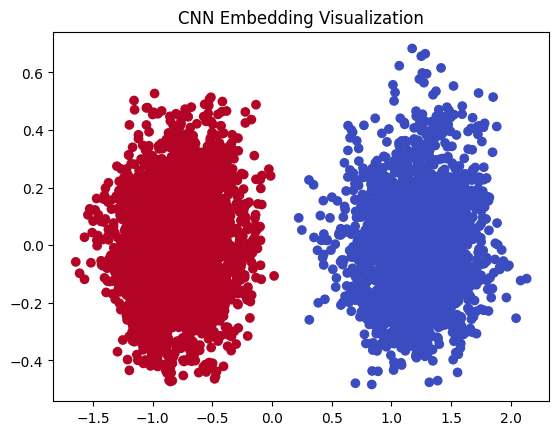

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
reduced = pca.fit_transform(train_embeddings[[f"emb_{i}" for i in range(64)]])
plt.scatter(reduced[:,0], reduced[:,1], c=train_embeddings["label"], cmap="coolwarm")
plt.title("CNN Embedding Visualization")
plt.show()

#### CNN → LLM Reasoning

#### Pass embeddings to LLM

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
def llm_reason_over_embedding(embedding_vector, extra_info=None):

    emb_list = [float(x) for x in embedding_vector]

    prompt = f"""
You are an expert in Predictive Maintenance for Aircraft Engines.

You are given a 64-dimensional numeric embedding vector produced by a 1D CNN.
Each embedding value represents hidden patterns learned from vibration,
temperature, pressure, and operational behavior across the last 15 cycles.

Your job is to ANALYZE these numbers and make a decision.

Embedding vector (64 values):
{emb_list}

### INSTRUCTIONS ###
1. Identify if the embedding values indicate:
   - Normal operation
   - Abnormal sensor behavior
   - Early signs of engine failure

2. Look for:
   - unusually high values
   - unusually low values
   - sharp spikes
   - negative values indicating sensor drift
   - clusters of activations

3. Provide:
   - A clear YES/NO: "Is engine close to failure?"
   - Failure risk (0–100%)
   - 3–5 sentence explanation based only on the numbers
   - Recommended maintenance action

### IMPORTANT ###
- You MUST give a full reasoning.
- Do NOT repeat the instructions.
- Do NOT summarize the problem.
- Directly analyze the embedding values and explain.
"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(DEVICE)
    outputs = llm.generate(**inputs, max_length=400)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

#### Pass CNN embeddings to LLM

In [ ]:
# ============================================================
# 🔥 CNN embeddings -> T5-small hybrid training & evaluation
# ============================================================

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, T5EncoderModel, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---------- 1) load embedding CSVs ----------
train_emb_path = "train_embeddings.csv"
test_emb_path  = "test_embeddings.csv"

train_df = pd.read_csv(train_emb_path)
test_df  = pd.read_csv(test_emb_path)

print("Train rows:", len(train_df), "Test rows:", len(test_df))

# ---------- 2) sanity checks ----------
emb_cols = [c for c in train_df.columns if c.startswith("emb_")]
assert len(emb_cols) > 0, "No embedding columns found (must be emb_0 ... emb_n)."
print("Embedding dim detected:", len(emb_cols))

# ---------- 3) Build text prompts from embeddings ----------
def embedding_row_to_prompt(row, emb_cols=emb_cols, prefix="Embedding:"):
    vals = [f"{row[c]:.6f}" for c in emb_cols]
    return prefix + " " + ", ".join(vals) + " -> Predict failure (1 or 0):"

train_df["prompt"] = train_df.apply(lambda r: embedding_row_to_prompt(r), axis=1)
test_df["prompt"]  = test_df.apply(lambda r: embedding_row_to_prompt(r), axis=1)

train_df["label_int"] = train_df["label"].astype(int)
test_df["label_int"]  = test_df["label"].astype(int)
#making sure numbers are in int form bcoz t5 needs label in int

# ---------- 4) class weights (for loss) ----------
labels = train_df["label_int"]
class_counts = labels.value_counts().sort_index()  # index 0 then 1
weights = torch.tensor([len(labels) / (2 * class_counts.loc[c]) for c in class_counts.index], dtype=torch.float).to(DEVICE)
print("Class counts:", class_counts.to_dict(), "Weights:", weights.tolist())

# ---------- 5) Tokenizer & Dataset ----------
MODEL_NAME = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

CONTEXT_MAX_LENGTH = 256
class EmbeddingTextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=CONTEXT_MAX_LENGTH):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.prompts = df["prompt"].tolist()
        self.labels = df["label_int"].tolist()

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        p = self.prompts[idx]
        inputs = self.tokenizer(p, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        item = {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

train_dataset = EmbeddingTextDataset(train_df, tokenizer)
eval_dataset  = EmbeddingTextDataset(test_df, tokenizer)

print("Train dataset size:", len(train_dataset), "Eval dataset size:", len(eval_dataset))

# ---------- 6) Model: T5 encoder + classifier (same pattern as your earlier T5BinaryClassifier) ----------
class T5EmbeddingClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME):
        super().__init__()
        self.encoder = T5EncoderModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.encoder.config.d_model, 2)
    def forward(self, input_ids=None, attention_mask=None, labels=None):
        enc = self.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        mask = attention_mask.unsqueeze(-1)
        masked_enc = enc * mask
        summed = masked_enc.sum(1)
        lengths = mask.sum(1).clamp(min=1e-9)
        pooled = summed / lengths
        logits = self.classifier(pooled)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=weights)
            loss = loss_fct(logits, labels)
        return {"loss": loss, "logits": logits}

model = T5EmbeddingClassifier().to(DEVICE)

# ---------- 7) Training arguments & Trainer ----------
training_args = TrainingArguments(
    output_dir="t5_on_embeddings",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_dir="t5_on_embeddings_logs",
    logging_steps=50,                    #for each 50 steps
    save_strategy="no",
    eval_strategy="epoch",
    fp16=torch.cuda.is_available()
)

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# ---------- 8) Train ----------
print("Starting T5 training on embeddings...")
trainer.train()
print("T5 training complete.")

# ---------- 9) Evaluation helper (sample-level) ----------
def evaluate_model_trainer(trainer, dataset):
    trainer.model.eval()
    loader = DataLoader(dataset, batch_size=32)
    all_preds, all_labels = [], []
    for batch in loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)    #moves batch data to GPU or CPU
        with torch.no_grad():
            outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs["logits"], dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Accuracy: {acc*100:.2f}%\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1: {f1:.4f}")
    print("Confusion Matrix:\n", cm)
    return all_labels, all_preds

print("\n--- Train evaluation (T5 on embeddings) ---")
_ = evaluate_model_trainer(trainer, train_dataset)

print("\n--- Test evaluation (T5 on embeddings) ---")
_ = evaluate_model_trainer(trainer, eval_dataset)

# ---------- 10) Unit-wise evaluation (last cycle per unit) ----------
# Select last cycle embedding row per unit from test_df
unit_last = test_df.sort_values(["unit", "cycle"]).groupby("unit").tail(1).reset_index(drop=True)
print("Unit-wise rows:", len(unit_last))

# Make a small dataset/wrapper for these last-cycle prompts
class SimplePromptDataset(Dataset):
    def __init__(self, prompts, labels, tokenizer, max_length=CONTEXT_MAX_LENGTH):
        self.prompts = prompts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.prompts)
    def __getitem__(self, idx):
        p = self.prompts[idx]
        inputs = self.tokenizer(p, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        return {"input_ids": inputs["input_ids"].squeeze(0),
                "attention_mask": inputs["attention_mask"].squeeze(0),
                "labels": torch.tensor(self.labels[idx], dtype=torch.long)}

unit_dataset = SimplePromptDataset(unit_last["prompt"].tolist(), unit_last["label_int"].tolist(), tokenizer)
print("\n--- Unit-wise evaluation (T5 on last-cycle embeddings) ---")
_ = evaluate_model_trainer(trainer, unit_dataset)

# ---------- 11) Save model (optional) ----------
# trainer.save_model("t5_on_embeddings_saved")

print("\nAll done. You can compare T5 results with your CNN baseline.")


Device: cuda
Train rows: 6000 Test rows: 1554
Embedding dim detected: 64
Class counts: {0: 2400, 1: 3600} Weights: [1.25, 0.8333333134651184]
Train dataset size: 6000 Eval dataset size: 1554
Starting T5 training on embeddings...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sayalidjadhav848 (sayalidjadhav848-d-y-patil-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.079200,0.044987
2,0.037000,0.017601
3,0.019200,0.015065


T5 training complete.

--- Train evaluation (T5 on embeddings) ---
Accuracy: 99.83%
Precision: 0.9997
Recall: 0.9975
F1: 0.9986
Confusion Matrix:
 [[2399    1]
 [   9 3591]]

--- Test evaluation (T5 on embeddings) ---
Accuracy: 99.74%
Precision: 0.9974
Recall: 0.9974
F1: 0.9974
Confusion Matrix:
 [[776   2]
 [  2 774]]
Unit-wise rows: 389

--- Unit-wise evaluation (T5 on last-cycle embeddings) ---
Accuracy: 99.74%
Precision: 0.9949
Recall: 1.0000
F1: 0.9974
Confusion Matrix:
 [[194   1]
 [  0 194]]

All done. You can compare T5 results with your CNN baseline.
